In [1]:
from wobble.interp import interp
import h5py
import wobble
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Read in data

In [2]:
starid = 'hip54287'
filename = 'data/'+starid+'_e2ds.hdf5'

In [3]:
with h5py.File(filename) as f:
    order = 56
    data = np.log(f['data'][order])
    data_xs = np.log(f['xs'][order])
    ivars = np.copy(f['ivars'][order])
    pipeline_rvs = -1. * np.copy(f['pipeline_rvs'])
    bervs = -1. * np.copy(f['bervs'])
    airms = np.copy(f['airms'])

In [4]:
for n in range(len(data)):
    data[n] -= wobble.fit_continuum(data_xs[n], data[n], ivars[n])

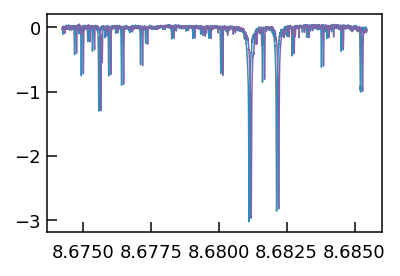

In [5]:
plt.plot(data_xs[0], data[0])
plt.plot(data_xs[5], data[5])

In [6]:
len(data)

75

In [7]:
a = wobble.star(starid+'_e2ds.hdf5', filepath='data/', orders=[order])
a.initialize_model(0, 'star')
star_model_xs, star_model_ys = a.model_xs_star[0], a.model_ys_star[0]
a.initialize_model(0, 't')
t_model_xs, t_model_ys = a.model_xs_t[0], a.model_ys_t[0]

initializing star model...
initializing tellurics model...


## Build wobbleflow framework

In [8]:
import tensorflow as tf

In [9]:
%time
T = tf.float64
data_tensor = tf.constant(data, dtype=T)
xs_tensor = tf.constant(data_xs, dtype=T)
ivars_tensor = tf.constant(ivars, dtype=T)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 12.2 µs


In [10]:
starting_rvs = pipeline_rvs + np.random.normal(0., 100., len(pipeline_rvs))

In [11]:
speed_of_light = 2.99792458e8   # m/s

def doppler(v):
    frac = (1. - v/speed_of_light) / (1. + v/speed_of_light)
    return tf.sqrt(frac)

In [12]:
#setup a data object that functions like wobble.Data:
class Data(object):
    def __init__(self):
        self.N = len(pipeline_rvs)
        self.R = 1
        self.ys = data
        self.xs = data_xs
        self.ivars = ivars
        self.pipeline_rvs = pipeline_rvs
        self.bervs = bervs
        
    def make_tensors(self):
        self.ys_tensor = [tf.constant(y, dtype=T) for y in self.ys]
        self.xs_tensor = [tf.constant(x, dtype=T) for x in self.xs]
        self.ivars_tensor = [tf.constant(i, dtype=T) for i in self.ivars]
        
data = Data()

In [13]:
#setup a model object that functions like wobble.Model:
class Model(object):
    """
    Keeps track of all components in the model.
    """
    def __init__(self, data):
        self.components = []
        self.data = data
        
    def add_star(self, name):
        name = Star(self.data)
        self.components.append(name)
        
    def add_telluric(self, name):
        name = Telluric(self.data)
        self.components.append(name)
        
class Component(object):
    """
    Generic class for an additive component in the spectral model.
    """
    def __init__(self, data):
        self.rvs_block = [np.zeros(data.N) for r in range(data.R)]
        self.model_xs = [np.zeros(100) for r in range(data.R)]
        self.model_ys = [np.zeros(100) for r in range(data.R)]
        
        
    def make_tensors(self):
        """
        Convert attributes to TensorFlow variables in preparation for optimizing.
        """
        self.rvs_block_tensor = [tf.Variable(v, dtype=T) for v in self.rvs_block]
        self.model_ys_tensor = [tf.Variable(m, dtype=T) for m in self.model_ys]
        self.model_xs_tensor = [tf.Variable(m, dtype=T) for m in self.model_xs]
        
    def shift_and_interp(self, r, xs, rv):
        """
        Apply a Doppler shift to the model at order r and output interpolated values at xs.
        """
        shifted_xs = xs + tf.log(doppler(rv))
        return interp(shifted_xs, self.model_xs_tensor[r], self.model_ys_tensor[r])        

class Star(Component):
    """
    A star (or generic celestial object)
    """
    def __init__(self, data):
        Component.__init__(self, data)
        self.rvs_block = [starting_rvs for r in range(data.R)]
        self.initialize_model(data)
    
    def initialize_model(self, data):
        # hackety fucking hack
        self.model_xs = [star_model_xs]
        self.model_ys = [star_model_ys]       

class Telluric(Component):
    """
    Sky absorption
    """
    def __init__(self, data):
        Component.__init__(self, data)
        self.initialize_model(data)
        
    def initialize_model(self, data):
        # hackety fucking hack
        self.model_xs = [t_model_xs]
        self.model_ys = [t_model_ys]

In [14]:
%time
model = Model(data)
model.add_star('a')
model.add_telluric('t')
for c in model.components:
    c.make_tensors()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.82 µs


In [15]:
r = 0
shifted_xs_star = xs_tensor + tf.log(doppler(model.components[0].rvs_block_tensor[r][:, None]))
models_star = interp(shifted_xs_star, model.components[0].model_xs_tensor[r], model.components[0].model_ys_tensor[r])
shifted_xs_t = xs_tensor + tf.log(doppler(model.components[1].rvs_block_tensor[r][:, None]))
models_t = interp(shifted_xs_t, model.components[1].model_xs_tensor[r], model.components[1].model_ys_tensor[r])
models = models_star + models_t
nll = 0.5*tf.reduce_sum(tf.square(data_tensor - models) * ivars_tensor)

In [16]:
grad_model_star = tf.gradients(nll, model.components[0].model_ys_tensor[r])
grad_rvs_star = tf.gradients(nll, model.components[0].rvs_block_tensor[r])
grad_model_t = tf.gradients(nll, model.components[1].model_ys_tensor[r])
grad_rvs_t = tf.gradients(nll, model.components[1].rvs_block_tensor[r])

## Check some gradients

In [17]:
session = tf.Session()
session.run(tf.global_variables_initializer())
tf_grad = session.run(grad_rvs_star)[0]

In [18]:
opt_grad_rvs_star = tf.train.AdamOptimizer(10.).compute_gradients(nll, var_list=[model.components[0].rvs_block_tensor[r]])
opt_grad = session.run(opt_grad_rvs_star)[0][0]
print("Optimizer gradients - TF.gradient():")
print(opt_grad - tf_grad)

Optimizer gradients - TF.gradient():
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


In [19]:
rvs = tf.placeholder(T, (75,))
shifted_xs_star2 = xs_tensor + tf.log(doppler(rvs[:,None]))
models_star2 = interp(shifted_xs_star2, model.components[0].model_xs_tensor[r], model.components[0].model_ys_tensor[r])
models2 = models_star2 + models_t
nll2 = 0.5*tf.reduce_sum(tf.square(data_tensor - models2) * ivars_tensor)

In [20]:
num_grads = np.zeros_like(tf_grad)
rvs0 = model.components[0].rvs_block[r]
#print(rvs0 - session.run(model.components[0].rvs_block_tensor[r]))
nll_0 = session.run(nll2, feed_dict={rvs:rvs0})
d_rvs = 0.001
for n in range(75):
    rvs1 = np.copy(rvs0)
    rvs1[n] += d_rvs
    nll_1 = session.run(nll2, feed_dict={rvs:rvs1})
    num_grads[n] = np.copy((nll_1 - nll_0)/d_rvs)
print("Fractional difference between numerical gradients & TF gradient at each RV_star:")
print((num_grads - tf_grad) / np.median(np.abs(tf_grad)))

Fractional difference between numerical gradients & TF gradient at each RV_star:
[ 4.28200768e-05 -1.43484618e-05  4.46799764e-04  1.46691706e-05
 -2.11162422e-04  1.24143576e-04 -2.98207315e-04 -4.37132387e-04
  1.14500521e-04 -1.77053620e-04 -5.61272516e-04 -7.54084499e-05
  6.45479456e-04 -4.65913839e-05 -7.34994323e-05  1.63979149e-04
 -8.45420135e-05 -8.41107201e-05  1.03836820e-04  3.29061166e-04
  1.62642959e-04  5.35738012e-04 -1.25375025e-04  5.15559960e-05
 -9.36175438e-04  1.08289002e-04  6.45372625e-05  6.62112315e-05
 -1.73478769e-04 -5.29878868e-05  1.17255602e-04  2.80005248e-04
  4.11023743e-04 -2.05895963e-04 -5.95754052e-05  4.09016405e-04
  1.20199756e-04 -7.61534267e-05  1.51928753e-04  3.11806626e-04
  2.18294785e-04  7.78778274e-05  3.31482444e-04  1.35112741e-04
  3.92725031e-04 -1.10799018e-04  1.12016154e-03 -6.70438470e-05
  2.06275934e-05  3.29189530e-05 -4.74770992e-06  1.77353656e-05
 -7.12973857e-05 -1.28919307e-03 -7.13552449e-05 -2.55441014e-04
 -8.13296

## Optimize

In [21]:
opt_model_star = tf.train.AdamOptimizer(0.01).minimize(nll, var_list=[model.components[0].model_ys_tensor[r]])
opt_rvs_star = tf.train.AdamOptimizer(10.).minimize(nll, var_list=model.components[0].rvs_block_tensor[r])
opt_model_t = tf.train.AdamOptimizer(0.1).minimize(nll, var_list=[model.components[1].model_ys_tensor[r]])
opt_rvs_t = tf.train.AdamOptimizer(10.).minimize(nll, var_list=model.components[1].rvs_block_tensor[r])

In [22]:
%%time
session = tf.Session()
session.run(tf.global_variables_initializer())

nll_history = []
for i in tqdm(range(80)):
    session.run(opt_rvs_star)
    nll_history.append(session.run(nll))
    session.run(opt_rvs_t)
    nll_history.append(session.run(nll))
    session.run(opt_model_star)
    nll_history.append(session.run(nll))
    session.run(opt_model_t)
    nll_history.append(session.run(nll))          

soln_model_star = session.run(model.components[0].model_ys_tensor[r])
soln_rvs_star = session.run(model.components[0].rvs_block_tensor[r])
soln_model_t = session.run(model.components[1].model_ys_tensor[r])
soln_rvs_t = session.run(model.components[1].rvs_block_tensor[r])

100%|██████████| 80/80 [00:36<00:00,  2.17it/s]

CPU times: user 46.7 s, sys: 6.96 s, total: 53.7 s
Wall time: 37.3 s


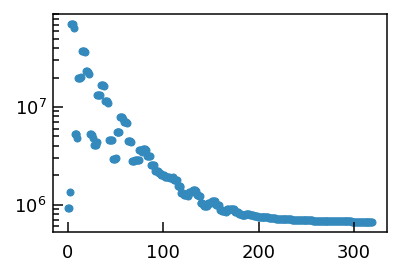

In [23]:
plt.scatter(np.arange(len(nll_history)), nll_history)
ax = plt.gca()
ax.set_yscale('log')

8.535875484800851


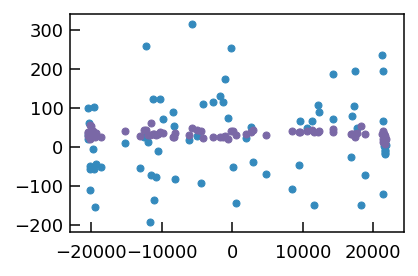

In [24]:
plt.scatter(pipeline_rvs, starting_rvs - pipeline_rvs)
plt.scatter(pipeline_rvs, soln_rvs_star - pipeline_rvs)
print(np.std(soln_rvs_star - bervs))

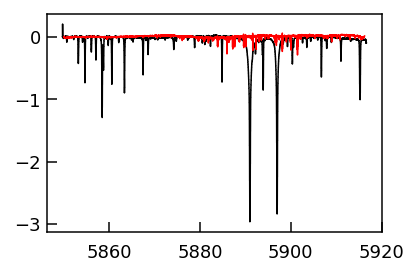

In [25]:
plt.step(np.exp(star_model_xs), soln_model_star, color='k')
plt.step(np.exp(t_model_xs), soln_model_t, color='r')